In [1]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,matplotlib,json,sklearn,topicpy -a Filippo_Valle -g -r -b -w

2025-01-15 11:16:01.792311: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 11:16:01.794848: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 11:16:01.803138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 11:16:01.816759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 11:16:01.820831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 11:16:01.830807: I tensorflow/core/platform/cpu_feature_gu

Author: Filippo_Valle

Last updated: Wed Jan 15 2025

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

pandas    : 1.5.0
numpy     : 1.23.5
matplotlib: 3.6.0
json      : 2.0.9
sklearn   : 1.1.2
topicpy   : 0.3.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 6.8.0-51-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Git hash: e8c5586e8976bb92ffdc9e396bbed3060fd04813

Git repo: git@github.com:fvalle1/topics.git

Git branch: HEAD

Watermark: 2.4.3



In [2]:
import requests as rq
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from topicpy.TCGA_files import get_tcga_tissue
from sklearn import metrics
from topicpy.hsbmpy import *
from topicpy.hsbmpy import normalise_score
import os

2025-01-15 16:23:46.361732: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 16:23:46.364432: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 16:23:46.372826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 16:23:46.386410: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 16:23:46.390496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 16:23:46.400754: I tensorflow/core/platform/cpu_feature_gu

## read data

In [3]:
level = 1
algorithm = 'topsbm'
directory = f"{os.getcwd()}/datasets/gtex10"
L=get_max_available_L(directory, algorithm)
df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_clusters.head()

,Cluster 1
0,GTEX-YB5K-0526-SM-5LUAS
1,GTEX-13FTY-0426-SM-5IJC2
2,GTEX-14ICL-1826-SM-5RQIY
3,GTEX-SIU8-0426-SM-4BRUE
4,GTEX-1IDJC-0426-SM-B2LW1


In [4]:
df_files = pd.read_csv("%s/files.dat"%directory, index_col=[0], header=[0]).dropna(axis=1, how='all').dropna(axis=0, how='all')
samples = pd.read_csv("%s/%s/%s_level_0_clusters.csv"%(directory,algorithm,algorithm), header=[0]).astype(str).values.ravel()
samples=samples[samples!="nan"]
df_files = df_files.reindex(index=samples).dropna(how="all", axis=0).fillna("unknown")
labels = df_files.columns
labels

Index(['SMATSSCR', 'SMCENTER', 'SMPTHNTS', 'SMRIN', 'SMTS', 'SMTSD', 'SMUBRID',
       'SMTSISCH', 'SMTSPAX', 'SMNABTCH', 'SMNABTCHT', 'SMNABTCHD', 'SMGEBTCH',
       'SMGEBTCHD', 'SMGEBTCHT', 'SMAFRZE', 'SMGTC', 'SME2MPRT', 'SMCHMPRS',
       'SMNTRART', 'SMMAPRT', 'SMEXNCRT', 'SMGNSDTC', 'SMUNMPRT', 'SMRDLGTH',
       'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT', 'SMRRNANM',
       'SMRDTTL', 'SMVQCFL', 'SMTRSCPT', 'SMMPPDPR', 'SMUNPDRD', 'SMNTRNRT',
       'SMMPUNRT', 'SMEXPEFF', 'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG',
       'SME2SNSE', 'SMMFLGTH', 'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE',
       'SME1PCTS', 'SMRRNART', 'SME1MPRT', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

In [5]:
labels=['SMTS', "SMTSD"]
#labels = ["primary_site", "tissue_hd"]

In [ ]:
from topicpy.hsbmpy import clusteranalysis
clusteranalysis(directory,labels)

In [10]:
##useful for R clustree plot
def reindex(x):
    i=0
    last=x[0]
    new = []
    for xi in x:
        if xi == last:
            pass
        else:
            i+=1
            last=xi
        new.append(i)
    return new

df_labels = pd.DataFrame()
shape = df_clusters.dropna().shape
files = pd.read_csv("%s/%s/%s_level_3_clusters.csv"%(directory,algorithm,algorithm), header=[0]).astype(str).values.ravel()
files = files[files!="nan"]


for level in np.arange(L+1)[::-1]:
    df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,level), header=[0])
    print("level ", level, "with ", df_clusters.shape[1], " clusters")
    currentlevellabels = []
    for file in files:
        s = df_clusters[df_clusters.isin([file])].any(axis = 0)
        a = s.index[s]
        currentlevellabels.append(int(a[0][8:])-1)
    df_labels.insert(0,'l%d'%level,currentlevellabels)
    del currentlevellabels
filelabels = []
filesublabels = []
for file in files:
    try:
        filelabels.append(get_file(file, df_files)[labels[0]])
        filesublabels.append(get_file(file, df_files)[labels[1]])
    except:
        filelabels.append('unknown')
        filesublabels.append('unknown')
        print(*sys.exc_info())
df_labels.insert(0,'tissue', filelabels)
df_labels.insert(0,'subtissue', filesublabels)
df_labels.sort_values(by=['tissue','subtissue'], inplace=True)
df_labels.sort_values(by=["l%d"%l for l in np.arange(L+1)[::-1]], axis=0, inplace=True)
filelabels = df_labels['tissue']
filesublabels = df_labels['subtissue']
df_labels = df_labels.apply(reindex, axis=0)
df_labels['tissue']=filelabels
df_labels['subtissue']=filesublabels
df_labels.to_csv("%s/%s/topsbm_labels.csv"%(directory,algorithm), index=False, header=True)

level  3 with  36  clusters
level  2 with  28  clusters
level  1 with  8  clusters
level  0 with  1  clusters


In [15]:
if "clustersizes.txt" in os.listdir(directory):
    with open("%s/clustersizes.txt"%directory, 'r') as f:
        xl=np.array(f.read().split()).astype(int)
else:
    try:
        xl = getclustersizesarray(directory, L)
        with open("%s/clustersizes.txt" % directory, 'w') as f:
            for x in xl:
                f.write("%d\n" % x)
    except:
        print(*sys.exc_info())
        print("cannot save clustersizes.txt")

if "topicsizes.txt" in os.listdir(directory):
    with open("%s/topicsizes.txt"%directory) as f:
        tl=np.array(f.read().split()).astype(int)
else:
    try:
        tl = gettopicsizesarray(directory, L)
        with open("%s/topicsizes.txt" % directory, 'w') as f:
            for x in tl:
                f.write("%d\n" % x)
    except:
        print("cannot save topicsizes.txt")

In [10]:
scores = {}
for label in labels:
    scores[label] = get_scores(directory, labels, verbose=False)[label]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')
norm_scores = scores.copy()
normalise_score(norm_scores, base_algorithm="shuffle")

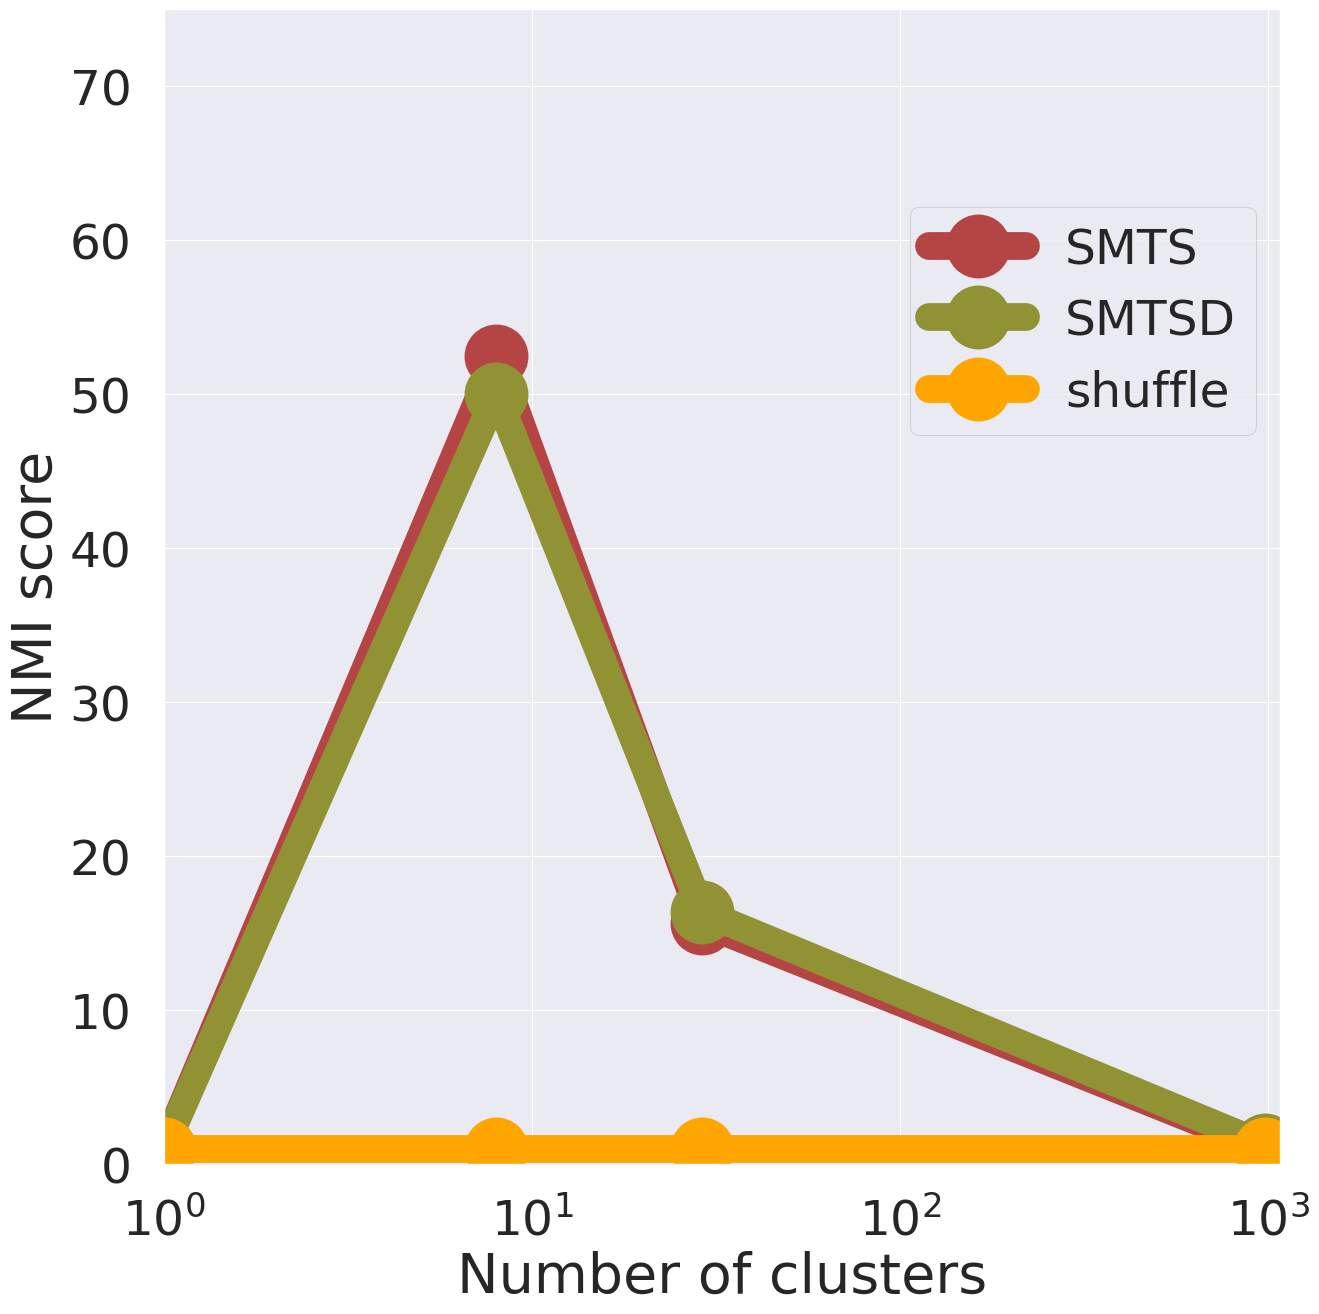

In [11]:
fig=plt.figure(figsize=(18,15))
ax = fig.subplots(1)
add_score_lines(ax,scores,V="norm_V", labels=labels+["shuffle"], alpha=1)
ax.set_xscale('log')
ax.set_ylim(0,75)

plt.show()
# fig.savefig("%s/metric_scores_hierstructure.pdf"%(directory))

In [7]:
data = {}
label = "SMTS"
for alg in ["topsbm", "lda", "tm", "wgcna", "hierarchical-log"]:
    print(alg)
    data[alg] = []
    for i in range (50):
        scores = {}
        scores[label] = get_scores(directory, labels, verbose=False, algorithm=alg)[label]
        scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm="topsbm" if alg !="tm" else "tm")
        norm_scores = scores.copy()
        normalise_score(norm_scores, base_algorithm="shuffle")
        data[alg].append(scores)

topsbm
lda
tm
wgcna
hierarchical-log


In [30]:
alg = "tm"
print(alg)
data[alg] = []
for i in range (50):
    scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm="topsbm")
    norm_scores = scores.copy()
    normalise_score(norm_scores, base_algorithm="shuffle")
    data[alg].append(scores)

tm


In [11]:
import pickle
with open("datasets/gtex10/scoresstat.pkl", 'wb') as f:
    pickle.dump(data, f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


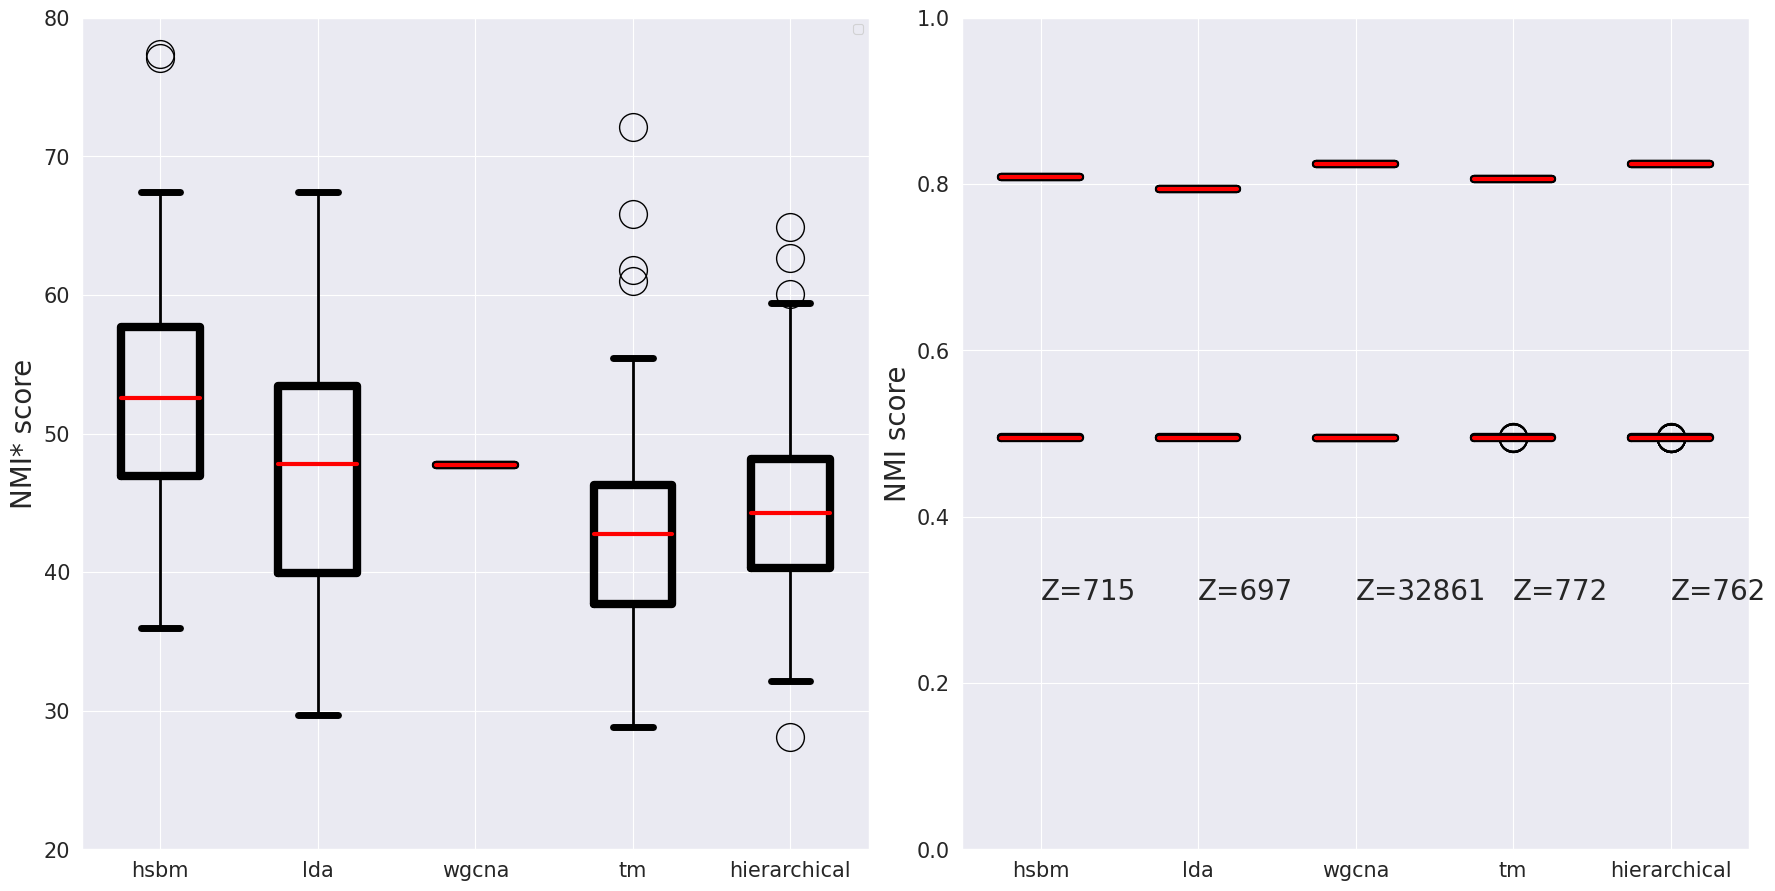

In [74]:
from scipy.stats import norm

p_value = lambda z_score: 2 * (1 - norm.cdf(abs(z_score)))


fig, axs = plt.subplots(1, 2, figsize=(18,9))

bins = np.arange(0,100,5)

kwargs = dict(flierprops={"c":"gray", "ms":20, "lw":5}, boxprops = {"lw":6}, whiskerprops={"lw":2}, capprops={"lw":5}, medianprops={"c":"red", "lw":3})

ax = axs[0]
ax.boxplot([np.max([d[label]["norm_V"] for d in data[alg]], axis=1) for alg in data.keys()], **kwargs)

ax.set_xticks(list(range(1,6)), ["hsbm", "lda", "wgcna", "tm", "hierarchical"], rotation=0, fontsize=15)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=15)
ax.legend()
ax.set_ylabel("NMI* score", fontsize=20)

ax = axs[1]
ax.boxplot([np.max([d[label]["V"] for d in data[alg]], axis=1) for alg in data.keys()], **kwargs)
ax.boxplot([np.max([d["shuffle"]["V"] for d in data[alg]], axis=1) for alg in data.keys()], **kwargs)

for i,alg in enumerate(data.keys()):
    x1 = np.max([d[label]["V"] for d in data[alg]], axis=1)
    x2 = np.max([d["shuffle"]["V"] for d in data[alg]], axis=1)
    Z = np.abs(np.mean(x1) - np.mean(x2)) / np.sqrt(1e-10+np.var(x1) + np.var(x2))
    ax.text(i+1, 0.3, "Z={:.0f}".format(Z), fontsize=20)

ax.set_xticks(list(range(1,6)), ["hsbm", "lda", "wgcna", "tm", "hierarchical"], rotation=0, fontsize=15)
ax.set_ylim(0,1)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=15)

ax.set_ylabel("NMI score", fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig("%s/metric_scores_comparison_hist.pdf"%(directory))

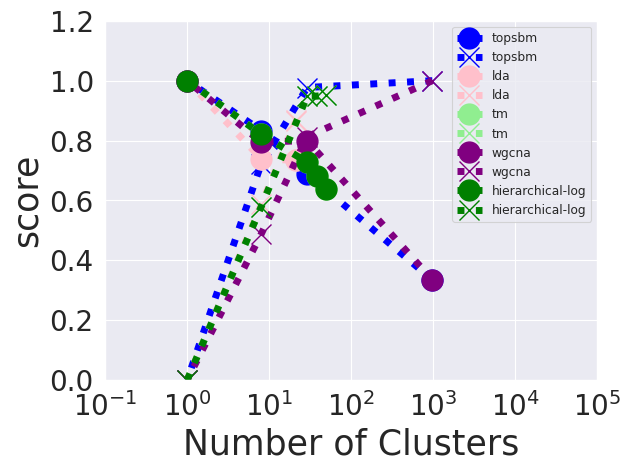

In [86]:
fig, ax = plt.subplots()

label = "SMTS"
colors = ["blue", "pink", "lightgreen", "purple", "green"]
for alg, c in zip(data.keys(), colors):
    ax.plot(
        np.average([d[label]["xl"] for d in data[alg]], axis=0),
        np.average([d[label]["c"] for d in data[alg]], axis=0),
        lw=5, ms=15, ls=":",
        c=c,
        marker="o",
        label=alg
    )
    ax.plot(
        np.average([d[label]["xl"] for d in data[alg]], axis=0),
        np.average([d[label]["h"] for d in data[alg]], axis=0),
        lw=5, ms=15, ls=":",
        c=c,
        marker="x",
        label=alg
    )

ax.legend()
ax.set_xscale('log')

ax.set_xlabel("Number of Clusters", fontsize=25)
ax.set_ylabel("score", fontsize=25)
ax.set_xlim(1, 2000)
ax.set_ylim(0, 1.1)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize=20)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=20)

plt.tight_layout()
plt.show()
fig.savefig("%s/metric_scores_comparison_errorbar.pdf"%(directory))

In [95]:
scores = {}
for label in labels:
    scores[label] = get_scores(directory, labels, verbose=False, algorithm="lda")[label]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')
norm_scores = scores.copy()
normalise_score(norm_scores, base_algorithm="shuffle")

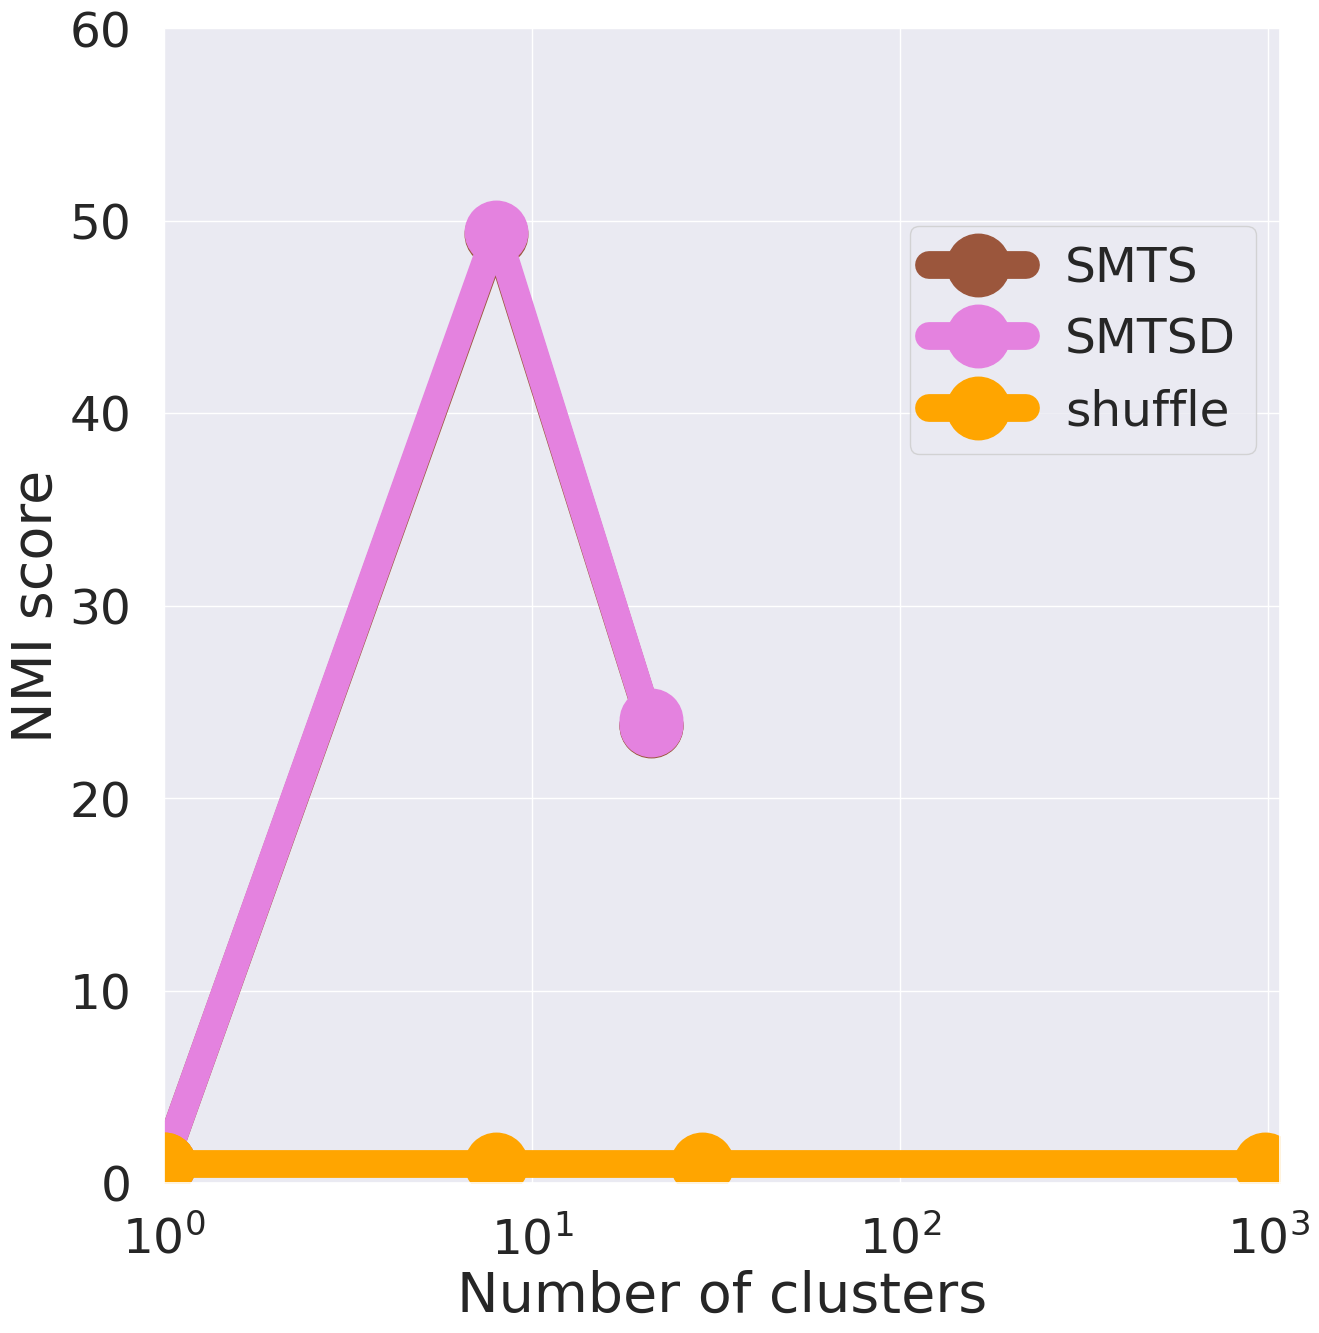

In [97]:
fig=plt.figure(figsize=(18,15))
ax = fig.subplots(1)
add_score_lines(ax,norm_scores,V="norm_V", labels=labels+["shuffle"], alpha=1)
ax.set_xscale('log')
ax.set_ylim(0,60)

plt.show()
fig.savefig("%s/metric_lda_scores_hierstructure.pdf"%(directory))

In [ ]:
fig=plt.figure(figsize=(18,15))
ax = fig.subplots(1)
#add_score_lines(ax,scores,[labels[0]],xl, h=True, c=True, alpha=1)
h = np.array(scores['hsbm']['h'])
c = np.array(scores['hsbm']['c'])
ax.plot(scores['hsbm']['xl'],h, marker='o', ls='--', lw=10, ms=40, label='homogeneity')
ax.plot(scores['hsbm']['xl'],c, marker='o', ls='-.', lw=10,ms=40, label='completeness')
ax.plot(scores['hsbm']['xl'],scores['hsbm']['V'], marker='o', ms=40, ls='-', lw=10, label='score')
ax.set_xscale('log')
ax.set_ylim(0,1)
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.legend(fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=15)

plt.xlabel('number of clusters', fontsize=35)
plt.ylabel('measure', fontsize=35)
plt.show()
fig.savefig("%s/metric_scores_primarysite.pdf"%(directory))

In [6]:
label = labels[0]
scores = {}
scores['hsbm'] = get_scores(directory, labels, df_files=df_files, algorithm = "topsbm", verbose=False)[label]
scores['hierarchical'] = get_scores(directory, labels, algorithm='hierarchical-log', verbose=False)[label]
scores['lda'] = get_scores(directory, labels, algorithm='lda', verbose=False)[label]
scores['tm']=get_scores(directory, labels, algorithm='tm', verbose=False)[label]
scores['wgcna']=get_scores(directory, labels, algorithm='wgcna', verbose=False)[label]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm='topsbm')

In [ ]:
scores["shuffle"]["xl"]=scores["shuffle"]["xl"][:-1]
scores["shuffle"]["V"]=scores["shuffle"]["V"][:-1]

In [12]:
scores['hsbm-log2'] = get_scores(directory, labels, algorithm='topsbm-log', verbose=False)[label]
scores['hsbm-log10'] = get_scores(directory, labels, algorithm='topsbm-log10', verbose=False)[label]
scores['hierarchical-tpm'] = get_scores(directory, labels, algorithm='hierarchical-tpm', verbose=False)[label]
scores['lda-tpm'] = get_scores(directory, labels, algorithm='lda-tpm', verbose=False)[label]
scores['wgcna-tpm']=get_scores(directory, labels, algorithm='wgcna-tpm', verbose=False)[label]

In [ ]:
scores["tissues"] = get_scores(directory, labels, algorithm='topsbm', verbose=False)[labels[0]]
scores["sub_tissues"] = get_scores(directory, labels, algorithm='topsbm', verbose=False)[labels[1]]
scores[labels[0]] = scores["tissues"]
scores[labels[1]] = scores["sub_tissues"]

In [14]:
if "mixed" in scores.keys():
    scores.pop("mixed")
norm_scores = scores.copy()
normalise_score(norm_scores, base_algorithm="shuffle")

In [8]:
analyses = {
    "all": ['hsbm', 'tm', 'hierarchical', 'lda', 'wgcna', 'shuffle'],
    "hsbm": ["hsbm", "hsbm-log2","hsbm-log10",'shuffle'],
    "subtissues": ["tissues", "sub_tissues",'shuffle']
}

In [ ]:
analysis = "hsbm"

fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores, V="norm_V", labels=analyses[analysis])
#ax.set_xscale('linear')
plt.xlim(1,2000)
plt.ylim(-1,75)
plt.show()
# fig.savefig("%s/metric_scores_%s.pdf"%(directory,analysis))

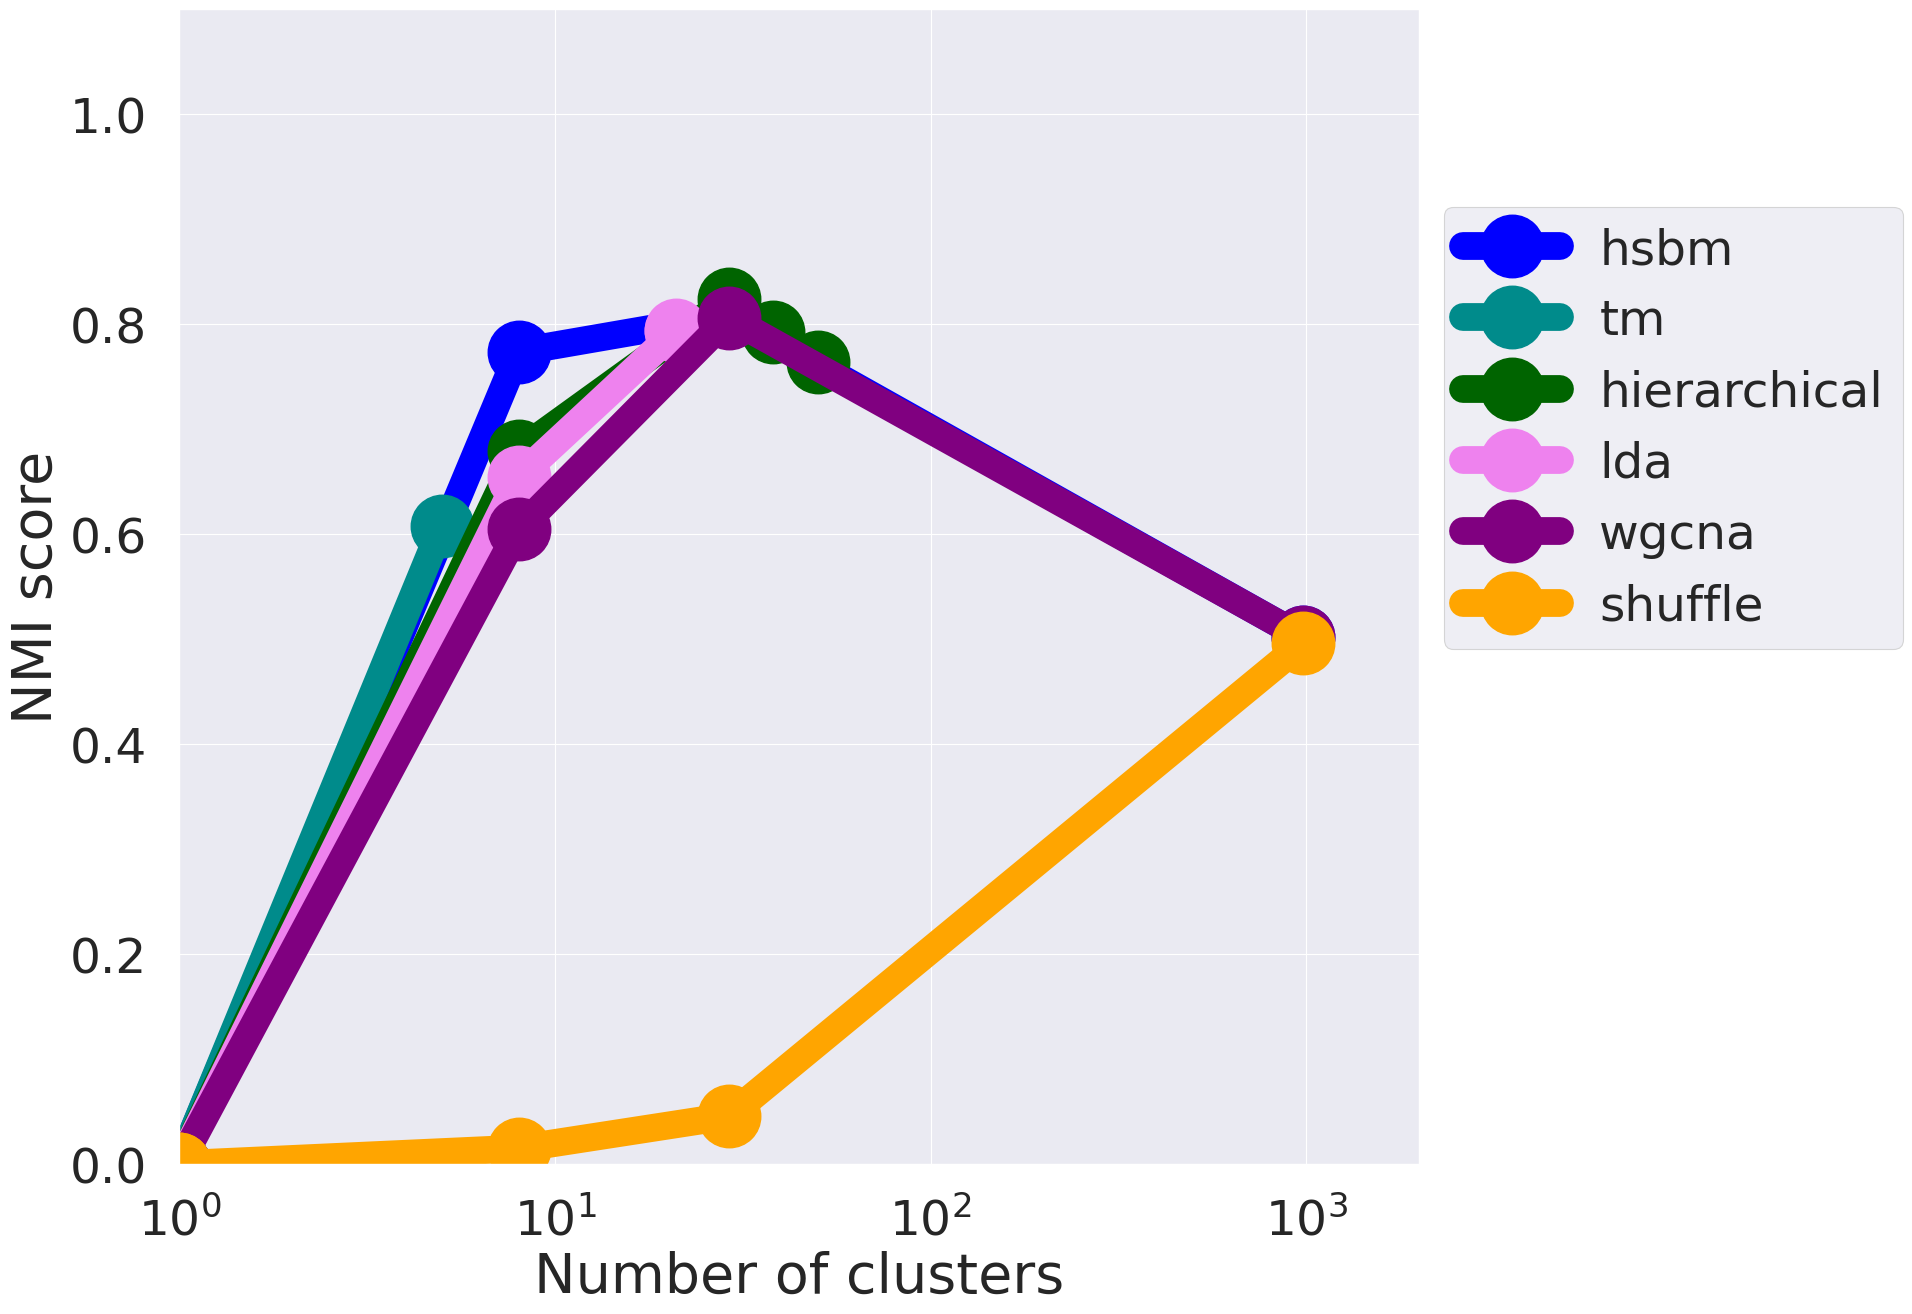

In [10]:
analysis = "all"

fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores, V="norm_V", labels=analyses[analysis])
#ax.set_xscale('linear')
plt.xlim(1,2000)
plt.ylim(-1,75)
plt.show()
fig.savefig("%s/metric_scores_%s.pdf"%(directory,analysis))

/tmp/ipykernel_434995/336755392.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=["hsbm","lda", "hierarchical","wgcna"], fontsize=35)


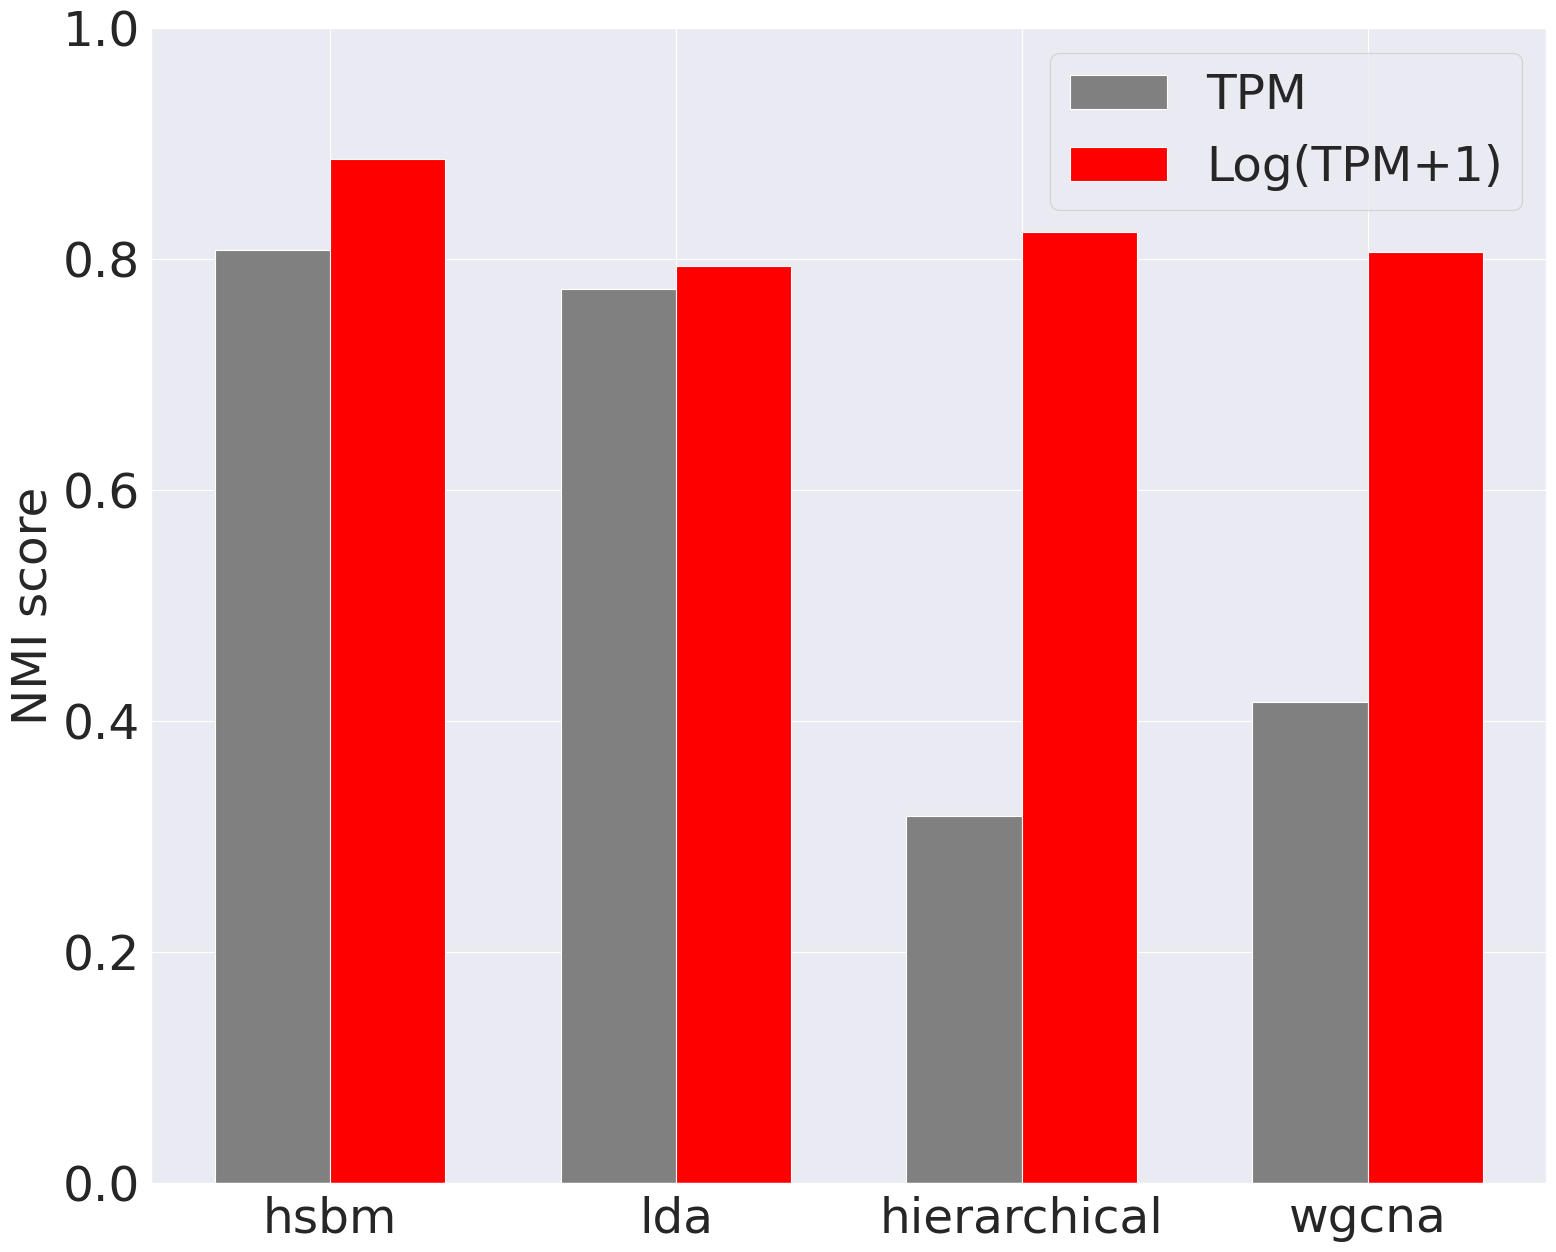

In [18]:
bar_data = {}
bar_data["tpm"] = {}
bar_data["log"] = {}

for alg in ["hsbm", "lda-tpm", "hierarchical-tpm", "wgcna-tpm"]:
    bar_data["tpm"][alg] = max(scores[alg]["V"])
for alg in ["hsbm-log2", "lda", "hierarchical", "wgcna"]:
    bar_data["log"][alg] = max(scores[alg]["V"])
    
n_algs = 4
fig, ax = plt.subplots(figsize=(18,15))
ax.bar([x*2.4 for x in range(n_algs)], list(zip(*bar_data["tpm"].items()))[1],color="gray", label="TPM")
ax.bar([0.8+x*2.4 for x in range(n_algs)], list(zip(*bar_data["log"].items()))[1], color="red", label="Log(TPM+1)")
ax.set_xticklabels(labels=["hsbm","lda", "hierarchical","wgcna"], fontsize=35)
ax.set_xticks([0.4+x*2.4 for x in range(n_algs)])
ax.tick_params(labelsize=35)
ax.set_ylim(0.,1)
ax.legend(fontsize=35)
ax.set_ylabel("NMI score", fontsize=35)

plt.show()
fig.savefig(f"{directory}/metric_scores_bars_log.pdf")

# Clustering consensus

In [8]:
clusters = {}
labels = {}
algs = ["topsbm", "tm", "lda", "wgcna", "hierarchical-log"]
for algorithm, l in zip(algs,[1,0, 2, 1, 2]):
    clusters[algorithm]=pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,l), header=[0])
    print(algorithm, clusters[algorithm].shape[1])
    labels[algorithm] = []
    for sample in samples:
        labels[algorithm].append(clusters[algorithm].columns[(clusters[algorithm]==sample).any()].values[0])

topsbm 29
tm 5
lda 28
wgcna 30
hierarchical-log 29


In [9]:
from sklearn.metrics import v_measure_score
for alg1, alg2 in zip(["topsbm", "topsbm", "topsbm", "topsbm", "tm", "tm", "tm", "lda", "lda", "wgcna"],["tm","lda", "wgcna", "hierarchical-log", "lda", "wgcna", "hierarchical-log", "wgcna", "hierarchical-log", "hierarchical-log"]):
    print(alg1, " & ", alg2.replace("-log",""), " & ", "{:.3f}".format(float(v_measure_score(labels[alg1], labels[alg2]))), "\\\\ \hline")

topsbm  &  tm  &  0.573 \\ \hline
topsbm  &  lda  &  0.804 \\ \hline
topsbm  &  wgcna  &  0.772 \\ \hline
topsbm  &  hierarchical  &  0.867 \\ \hline
tm  &  lda  &  0.638 \\ \hline
tm  &  wgcna  &  0.707 \\ \hline
tm  &  hierarchical  &  0.610 \\ \hline
lda  &  wgcna  &  0.804 \\ \hline
lda  &  hierarchical  &  0.842 \\ \hline
wgcna  &  hierarchical  &  0.813 \\ \hline


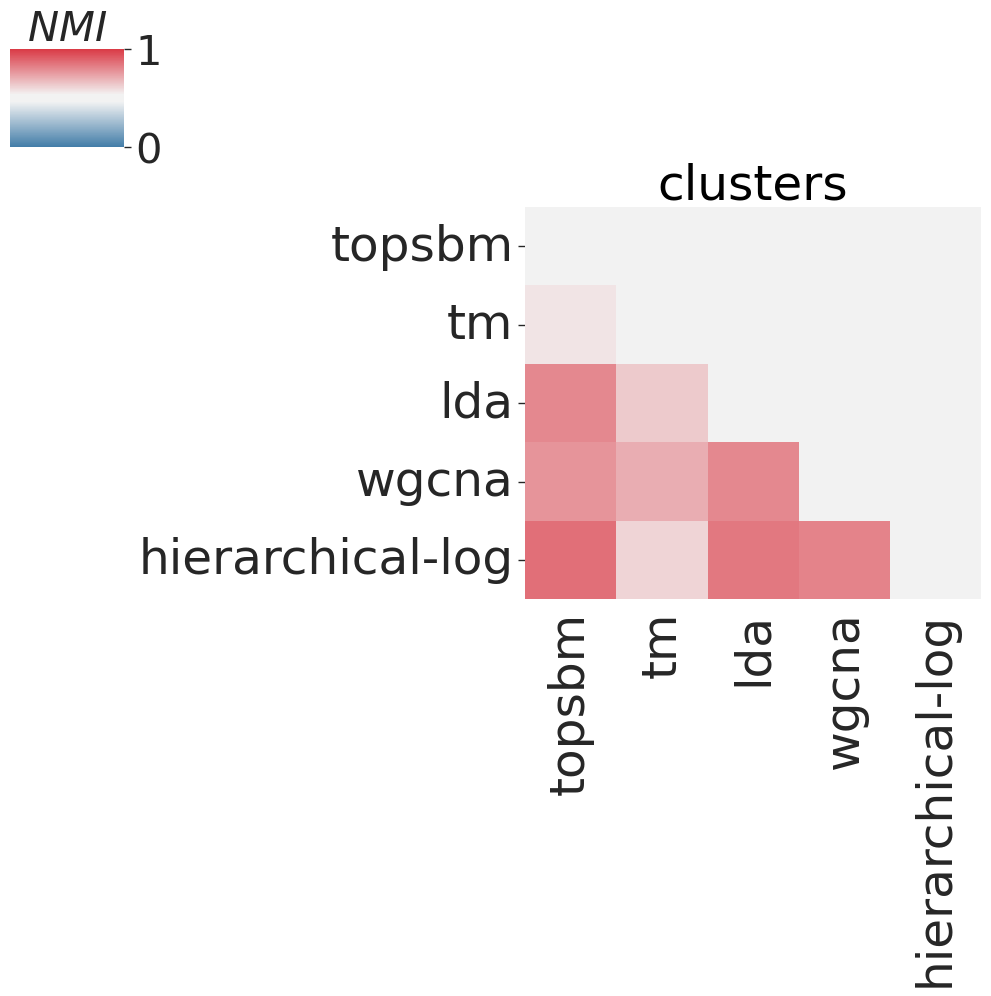

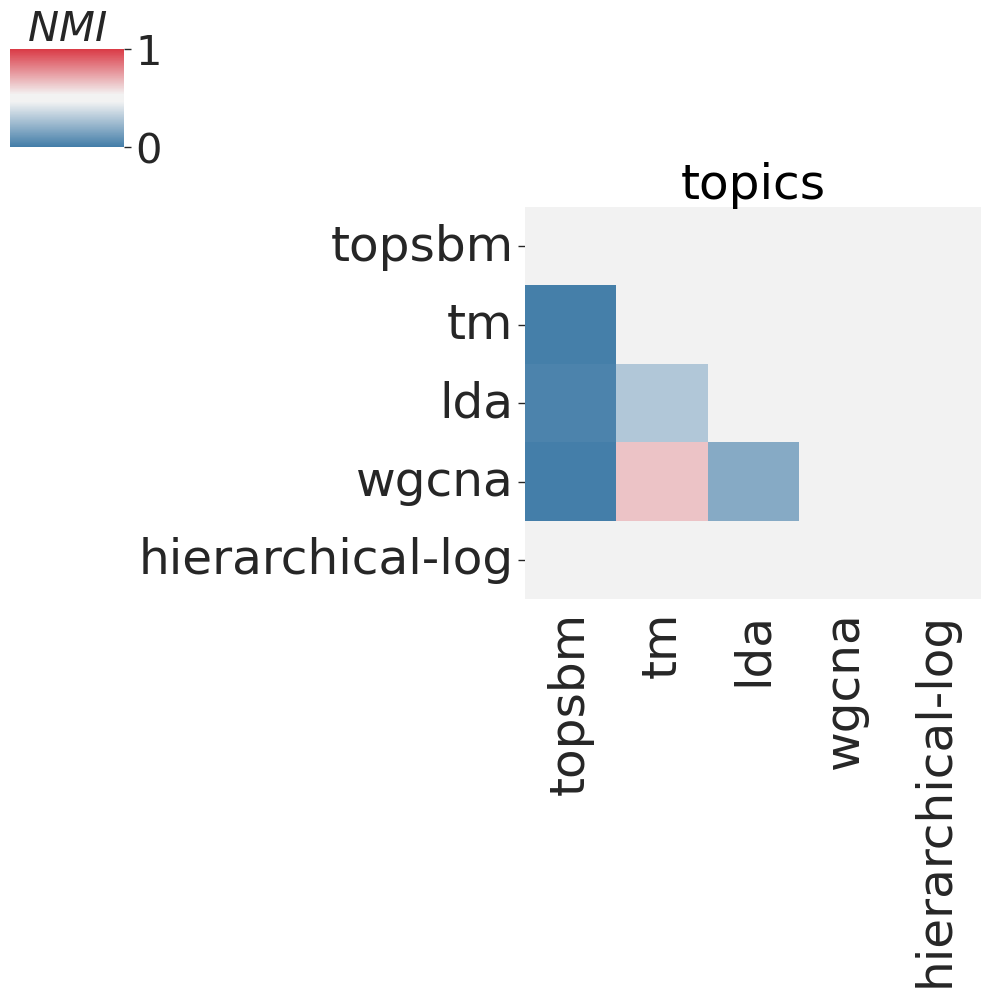

In [23]:
df_algs = pd.DataFrame(columns = algs, index=algs)
for alg1, alg2 in zip(["topsbm", "topsbm", "topsbm", "topsbm", "tm", "tm", "tm", "lda", "lda", "wgcna"],["tm","lda", "wgcna", "hierarchical-log", "lda", "wgcna", "hierarchical-log", "wgcna", "hierarchical-log", "hierarchical-log"]):
    df_algs.at[alg1,alg2]=float(v_measure_score(labels[alg1], labels[alg2]))
    
import seaborn as sns


cm = sns.clustermap(df_algs.fillna(0.5).transpose(), vmin=0, vmax=1, row_cluster=False, 
                    col_cluster=False,
                   cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True))
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_yticklabels(labels=algs, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=algs, rotation=90)
ax.tick_params(labelsize=35)

ax.set_title("clusters", fontsize=35, color="black")


cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("$NMI$", fontsize=30)
plt.tight_layout()
cm.savefig(f"{directory}/comparisons_C.pdf")

# this data are read from hSBM_topics.ipynb
df_algs = pd.DataFrame(columns = algs, index=algs)
df_algs.at["tm", "topsbm"]=0.014612
df_algs.at["lda", "topsbm"]=0.027809
df_algs.at["wgcna", "topsbm"]=0.011345
df_algs.at["lda", "tm"]=0.293432
df_algs.at["wgcna", "tm"]=0.655752
df_algs.at["wgcna", "lda"]=0.181433


cm = sns.clustermap(df_algs.fillna(0.5), vmin=0, vmax=1, row_cluster=False, 
                    col_cluster=False,
                   cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
                   )
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_yticklabels(labels=algs, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=algs, rotation=90)
ax.tick_params(labelsize=35)

ax.set_title("topics", fontsize=35, color="black")


cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("$NMI$", fontsize=30)
plt.tight_layout()
cm.savefig(f"{directory}/comparisons_T.pdf")

plt.show()